### **This notebook is used to generate segmentation results in relation to each of the four modality individually**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install nilearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation ,Dropout
from keras.layers.convolutional import Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
import pickle
import skimage.transform as skTrans
from nilearn import image
from nilearn.image import resample_img
import nibabel.processing
import warnings
import scipy
%matplotlib inline
import seaborn as sns
from scipy.ndimage import rotate
import random

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MRI Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/MRI Data/seg.nii.gz
/content/drive/MyDrive/MRI Data/flair.nii
/content/drive/MyDrive/MRI Data/fig.png
/content/drive/MyDrive/MRI Data/Output000.png
/content/drive/MyDrive/MRI Data/Output001.png
/content/drive/MyDrive/MRI Data/Output003.png
/content/drive/MyDrive/MRI Data/Output004.png
/content/drive/MyDrive/MRI Data/Output002.png
/content/drive/MyDrive/MRI Data/Output006.png
/content/drive/MyDrive/MRI Data/Output005.png
/content/drive/MyDrive/MRI Data/Output008.png
/content/drive/MyDrive/MRI Data/Output009.png
/content/drive/MyDrive/MRI Data/Output007.png
/content/drive/MyDrive/MRI Data/Output011.png
/content/drive/MyDrive/MRI Data/Output010.png
/content/drive/MyDrive/MRI Data/Output012.png
/content/drive/MyDrive/MRI Data/Output013.png
/content/drive/MyDrive/MRI Data/Output014.png
/content/drive/MyDrive/MRI Data/Output016.png
/content/drive/MyDrive/MRI Data/Output015.png
/content/drive/MyDrive/MRI Data/Output017.png
/content/drive/MyDrive/MRI Data/Output018.png
/

### **Data Preprocessing**

In [ ]:
Path= '/content/drive/MyDrive/MRI Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:      
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities
for i in p[:95]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)

In [ ]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [ ]:
InData= Data_Concatenate(Input_Data)

In [ ]:
with open("/content/drive/MyDrive/MRI Data/TrainingData NumPy/InData.pkl", "wb") as fp:   # pickling
   pickle.dump(InData,fp)

In [ ]:
with open("/content/drive/MyDrive/MRI Data/TrainingData NumPy/InData.pkl", "rb") as fp:   # un-pickling
  InData= pickle.load(fp)

### **Training and evaluating each modality**

In [ ]:
AIO= concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,3],dtype='float32')#  by changing index (0-flair, 1-T1ce, 2-T1, 3-T2) we can train the model against each individual modality
TRL=np.array(AIO[:,:,:,4],dtype='float32')#the 4th index of AIO contains the segmentation lables 

In [ ]:
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
AIO=TRL=0

In [ ]:
def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

In [ ]:
# Loding the Light weighted CNN
model = model(input_shape = (240,240,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return  ( 2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)/100

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# Compiling the model 
Adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

In [ ]:
# Fitting the model over the data
history = model.fit(X_train,Y_train,batch_size=32,epochs=10,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/10
66/66 [==============================] - 10s 134ms/step - loss: -0.1434 - accuracy: 0.9908 - dice_coef: 0.5849 - precision: 0.8805 - sensitivity: 0.9756 - specificity: 0.9987 - val_loss: -0.1308 - val_accuracy: 0.9906 - val_dice_coef: 0.6220 - val_precision: 0.8553 - val_sensitivity: 0.9584 - val_specificity: 0.9984
Epoch 2/10
66/66 [==============================] - 8s 127ms/step - loss: -0.1436 - accuracy: 0.9908 - dice_coef: 0.5718 - precision: 0.8894 - sensitivity: 0.9805 - specificity: 0.9988 - val_loss: -0.1326 - val_accuracy: 0.9910 - val_dice_coef: 0.6076 - val_precision: 0.8986 - val_sensitivity: 0.9463 - val_specificity: 0.9989
Epoch 3/10
66/66 [==============================] - 8s 127ms/step - loss: -0.1604 - accuracy: 0.9903 - dice_coef: 0.5633 - precision: 0.8982 - sensitivity: 0.9830 - specificity: 0.9989 - val_loss: -0.1231 - val_accuracy: 0.9914 - val_dice_coef: 0.6381 - val_precision: 0.9509 - val_sensitivity: 0.8862 - val_specificity: 0.9994
Epoch 4/10
66/6

In [ ]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 1s 41ms/step - loss: -0.1496 - accuracy: 0.9903 - dice_coef: 0.5936 - precision: 0.9164 - sensitivity: 0.9594 - specificity: 0.9990


[-0.14956140518188477,
 0.9903483986854553,
 0.5935714244842529,
 0.9164400100708008,
 0.9594081044197083,
 0.9989774227142334]

In [ ]:
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

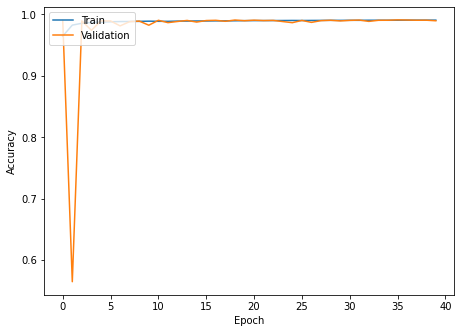

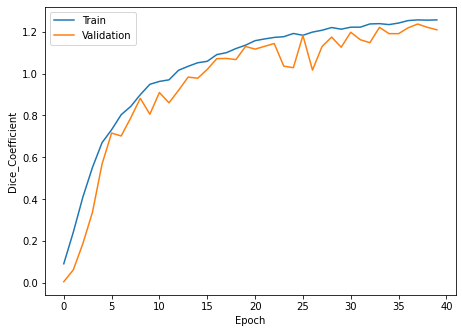

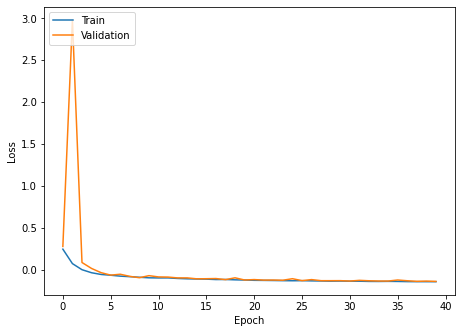

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)